### Uncertainty reduction in homogenization problems, Part-4
This notebook is similar to Part-2 w.r.t. traning and validation dataset, however, the LSTM model is not unidirectional, but it is bidirectional LSTM here. Moreover, unlike Pert-3, bidirectional LSTM here is with two layers. Lets compare predictions with one vs. two layers of bidirectional LSTM.

#### importing necessary modules

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


#### ETL process

In [0]:
from google.colab import files
import io
uploaded = files.upload()

Saving RVEsize-Homogenization2.txt to RVEsize-Homogenization2.txt


In [0]:
#Reading Dataset, input is cubic RVE size in oneDirection, output isAveraged sigma33 for 20 time steps
dataset= np.loadtxt(io.BytesIO(uploaded['RVEsize-Homogenization2.txt'])) 

RVEsize =  dataset[0]
series= dataset[1:]
series = np.transpose(series)
series

array([[-6.80145825e+01, -9.65273204e+01, -1.17443919e+02,
        -1.33899836e+02, -1.47049385e+02, -1.57593846e+02,
        -1.66056574e+02, -1.72849980e+02, -1.78303738e+02,
        -1.82682202e+02, -1.48191922e+02, -1.13008813e+02,
        -7.72693039e+01, -4.10833140e+01, -4.53871908e+00,
         3.22937215e+01,  6.93572756e+01,  1.06606454e+02,
         1.44004583e+02,  1.81522396e+02],
       [-3.85728372e+01, -5.49696605e+01, -6.75108209e+01,
        -7.80635725e+01, -8.73350760e+01, -9.56729234e+01,
        -1.03271046e+02, -1.10247634e+02, -1.16681362e+02,
        -1.22629082e+02, -9.01058811e+01, -5.71779755e+01,
        -2.38770753e+01,  9.76832072e+00,  4.37326010e+01,
         7.79922094e+01,  1.12525554e+02,  1.47312661e+02,
         1.82335075e+02,  2.17575669e+02],
       [-3.01645182e+01, -4.24959971e+01, -5.17744379e+01,
        -5.94965060e+01, -6.62278128e+01, -7.22595870e+01,
        -7.77656075e+01, -8.28585971e+01, -8.76157425e+01,
        -9.20917255e+01, -5.8

#### Lets visualize the datasets

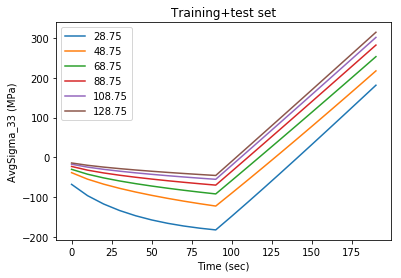

In [0]:
time=range(0,200,10)
plt.plot(time, series[0],  label='28.75')
plt.plot(time, series[1],  label='48.75')
plt.plot(time, series[2],  label='68.75')
plt.plot(time, series[3],  label='88.75')
plt.plot(time, series[4],  label='108.75')
plt.plot(time, series[5],  label='128.75')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+test set')
plt.legend()

plt.show()

#### prepare training Set for 2-to-1 bidirectional LSTM architecture

In [0]:
# series[0] training set e nile model training temon valo hoyna, tai bad deya hoise 
Xtrain=np.array([[series[1],series[2]],[series[2],series[3]],[series[3],series[4]]])
Ytrain = np.array([series[3],series[4],series[5]])
print(Xtrain)
print(Ytrain)

Xtrain.shape

[[[-3.85728372e+01 -5.49696605e+01 -6.75108209e+01 -7.80635725e+01
   -8.73350760e+01 -9.56729234e+01 -1.03271046e+02 -1.10247634e+02
   -1.16681362e+02 -1.22629082e+02 -9.01058811e+01 -5.71779755e+01
   -2.38770753e+01  9.76832072e+00  4.37326010e+01  7.79922094e+01
    1.12525554e+02  1.47312661e+02  1.82335075e+02  2.17575669e+02]
  [-3.01645182e+01 -4.24959971e+01 -5.17744379e+01 -5.94965060e+01
   -6.62278128e+01 -7.22595870e+01 -7.77656075e+01 -8.28585971e+01
   -8.76157425e+01 -9.20917255e+01 -5.82982513e+01 -2.42931169e+01
    9.90116280e+00  4.42671268e+01  7.87909101e+01  1.13461358e+02
    1.48269068e+02  1.83206352e+02  2.18266220e+02  2.53442698e+02]]

 [[-3.01645182e+01 -4.24959971e+01 -5.17744379e+01 -5.94965060e+01
   -6.62278128e+01 -7.22595870e+01 -7.77656075e+01 -8.28585971e+01
   -8.76157425e+01 -9.20917255e+01 -5.82982513e+01 -2.42931169e+01
    9.90116280e+00  4.42671268e+01  7.87909101e+01  1.13461358e+02
    1.48269068e+02  1.83206352e+02  2.18266220e+02  2.5344

(3, 2, 20)

In [0]:
Xtrain.shape

(3, 2, 20)

#### Start training

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<.1    ): #and logs.get('val_loss')<1
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,activation='relu',  return_sequences=True, input_shape=(2, 20))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu')),  
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(Xtrain, Ytrain, epochs=1000, callbacks=[callbacks]) 

Train on 3 samples
Epoch 1/1000
3/3 [==============================] - 5s 2s/sample - loss: 18160.3398
Epoch 2/1000
3/3 [==============================] - 0s 8ms/sample - loss: 12202.9736
Epoch 3/1000
3/3 [==============================] - 0s 7ms/sample - loss: 5404.6387
Epoch 4/1000
3/3 [==============================] - 0s 7ms/sample - loss: 3449.3118
Epoch 5/1000
3/3 [==============================] - 0s 7ms/sample - loss: 968.7698
Epoch 6/1000
3/3 [==============================] - 0s 7ms/sample - loss: 731.7866
Epoch 7/1000
3/3 [==============================] - 0s 7ms/sample - loss: 1216.5055
Epoch 8/1000
3/3 [==============================] - 0s 7ms/sample - loss: 1243.7935
Epoch 9/1000
3/3 [==============================] - 0s 7ms/sample - loss: 970.5695
Epoch 10/1000
3/3 [==============================] - 0s 7ms/sample - loss: 766.7625
Epoch 11/1000
3/3 [==============================] - 0s 8ms/sample - loss: 606.8342
Epoch 12/1000
3/3 [==============================] - 0s 6ms

#### Lets see the prediction at 148.75

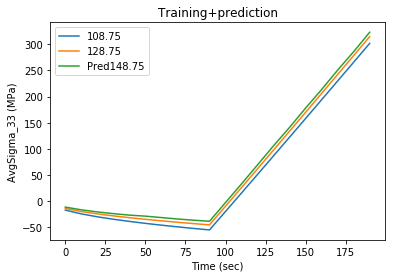

In [0]:
x7ForPrediction=np.array([[series[4],series[5]]])
pred148_75=model.predict(x7ForPrediction)

x8ForPrediction=np.array([[series[5],pred148_75[0]]])
pred168_75=model.predict(x8ForPrediction)

time=range(0,200,10)

plt.plot(time, series[4],  label='108.75')
plt.plot(time, series[5],  label='128.75')
plt.plot(time, pred148_75[0],  label='Pred148.75')  
#plt.plot(time, pred168_75[0],  label='Pred168.75')

plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+prediction')
plt.legend()

plt.show()

In [0]:
pred148_75


array([[-11.6285715, -16.830263 , -20.855507 , -24.155651 , -26.992771 ,
        -28.958544 , -31.670902 , -34.418774 , -36.65139  , -38.829556 ,
         -2.914219 ,  32.837456 ,  69.30215  , 105.882835 , 141.06805  ,
        178.04686  , 213.48874  , 250.71991  , 285.978    , 323.20132  ]],
      dtype=float32)

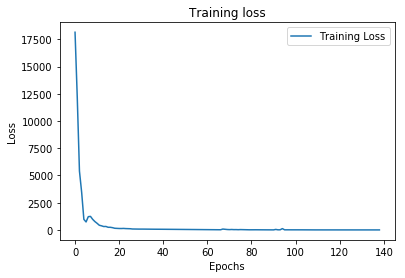

In [0]:
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs[0:], loss[0:],  label='Training Loss')
#plt.plot(epochs[0:], val_loss[0:],  label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()

plt.show()

#### Lets predict the next set, trained with the same model

In [0]:
Xtrain1=np.array([[series[1],series[2]],[series[2],series[3]],[series[3],series[4]],[series[4],series[5]]])
Ytrain1 = np.array([series[3],series[4],series[5],pred148_75[0]])
print(Xtrain1)
print(Ytrain1)

[[[-3.85728372e+01 -5.49696605e+01 -6.75108209e+01 -7.80635725e+01
   -8.73350760e+01 -9.56729234e+01 -1.03271046e+02 -1.10247634e+02
   -1.16681362e+02 -1.22629082e+02 -9.01058811e+01 -5.71779755e+01
   -2.38770753e+01  9.76832072e+00  4.37326010e+01  7.79922094e+01
    1.12525554e+02  1.47312661e+02  1.82335075e+02  2.17575669e+02]
  [-3.01645182e+01 -4.24959971e+01 -5.17744379e+01 -5.94965060e+01
   -6.62278128e+01 -7.22595870e+01 -7.77656075e+01 -8.28585971e+01
   -8.76157425e+01 -9.20917255e+01 -5.82982513e+01 -2.42931169e+01
    9.90116280e+00  4.42671268e+01  7.87909101e+01  1.13461358e+02
    1.48269068e+02  1.83206352e+02  2.18266220e+02  2.53442698e+02]]

 [[-3.01645182e+01 -4.24959971e+01 -5.17744379e+01 -5.94965060e+01
   -6.62278128e+01 -7.22595870e+01 -7.77656075e+01 -8.28585971e+01
   -8.76157425e+01 -9.20917255e+01 -5.82982513e+01 -2.42931169e+01
    9.90116280e+00  4.42671268e+01  7.87909101e+01  1.13461358e+02
    1.48269068e+02  1.83206352e+02  2.18266220e+02  2.5344

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<.1    ): #and logs.get('val_loss')<1
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,activation='relu',  return_sequences=True, input_shape=(2, 20))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu')),  #
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(Xtrain1, Ytrain1, epochs=1000, callbacks=[callbacks]) #, validation_data=(Xtest, Ytest)

Train on 4 samples
Epoch 1/1000
4/4 [==============================] - 5s 1s/sample - loss: 16532.5898
Epoch 2/1000
4/4 [==============================] - 0s 6ms/sample - loss: 9851.3711
Epoch 3/1000
4/4 [==============================] - 0s 5ms/sample - loss: 4915.3613
Epoch 4/1000
4/4 [==============================] - 0s 5ms/sample - loss: 4092.8872
Epoch 5/1000
4/4 [==============================] - 0s 5ms/sample - loss: 3995.2729
Epoch 6/1000
4/4 [==============================] - 0s 5ms/sample - loss: 2665.3867
Epoch 7/1000
4/4 [==============================] - 0s 6ms/sample - loss: 5014.0405
Epoch 8/1000
4/4 [==============================] - 0s 6ms/sample - loss: 1252.2301
Epoch 9/1000
4/4 [==============================] - 0s 6ms/sample - loss: 1937.1512
Epoch 10/1000
4/4 [==============================] - 0s 7ms/sample - loss: 2009.2576
Epoch 11/1000
4/4 [==============================] - 0s 7ms/sample - loss: 1511.8590
Epoch 12/1000
4/4 [==============================] - 0s

#### Lets see the prediction at 168.75

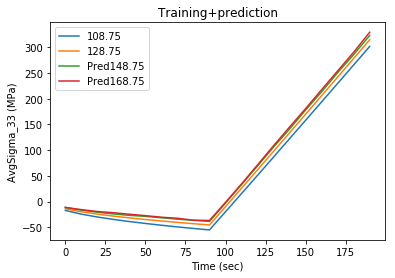

In [0]:

predx6=np.array([[series[5],pred148_75[0]]])
pred168_75=model.predict(predx6)

time=range(0,200,10)

plt.plot(time, series[4],  label='108.75')
plt.plot(time, series[5],  label='128.75')
plt.plot(time, pred148_75[0],  label='Pred148.75')  
plt.plot(time, pred168_75[0],  label='Pred168.75')
#plt.plot(time, pred168_75[0],  label='Pred188.75')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+prediction')
plt.legend()

plt.show()

In [0]:
pred168_75

array([[-11.430227 , -15.821242 , -19.471289 , -21.801062 , -24.7727   ,
        -27.532629 , -30.552141 , -32.617916 , -36.369106 , -36.933613 ,
         -1.6712118,  34.30515  ,  71.29924  , 108.6125   , 145.01543  ,
        180.81339  , 217.68884  , 254.21786  , 290.5204   , 329.4842   ]],
      dtype=float32)

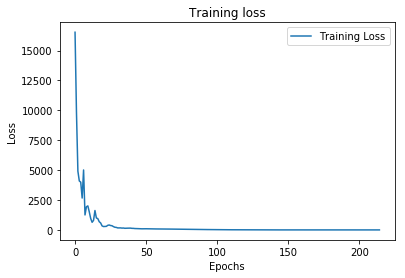

In [0]:
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs[0:], loss[0:],  label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()

plt.show()

#### Lets compare the prediction at 168.75, one vs two layers of bidirectional LSTM

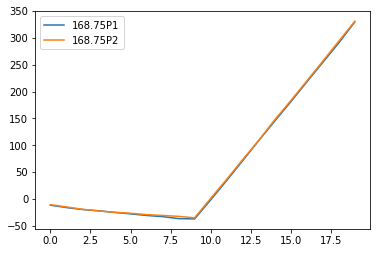

In [0]:

PrevPred168_75=[-10.436793, -14.661054, -18.945835, -22.045652, -24.69054 ,
        -26.36137 , -28.917046, -30.474792, -32.16388 , -34.88139 ,
          1.131721,  36.658592,  73.33767 , 109.10865 , 147.424   ,
        183.00839 , 219.61954 , 256.5306  , 293.7165  , 330.88852 ] 

time=range(0,20,1)
plt.plot(time, pred168_75[0],  label='2L-BLSTM_168.75')
plt.plot(time, PrevPred168_75,  label='1L-BLSTM_168.75P2')
plt.legend()
plt.show()

#### Now lets validate the predicted two last datasets ( at 128.75 and 148.75) with the simulated data

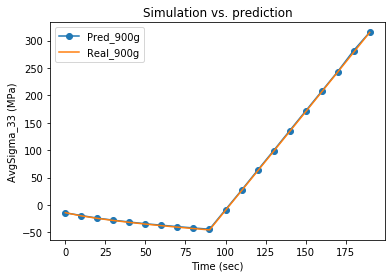

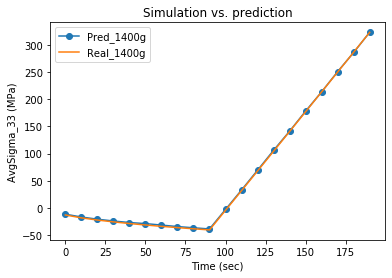

In [0]:

import matplotlib.pyplot as plt

P900g=[-14.418443, -19.39162, -24.110918, -27.865665, -31.204159, -34.44914,
       -37.00009, -39.686928, -42.03942, -44.401447, -8.649324, 26.772243,
       63.154934, 98.98916, 135.25005, 171.34344, 207.25742, 243.23119,
       281.8138, 315.15497]
R900g=[-14.19592589, -20.04594669, -24.57454637, -28.44065141, -31.88423916,
       -35.0242865,  -37.93074036, -40.64935218, -43.21230054, -45.64335473,
       -9.93606781, 25.87051547, 61.76482026, 97.73737847, 133.7802792,
       169.8868897, 206.0515251, 242.2693029, 278.5360146, 314.8479048]

P1400g=[-11.6285715, -16.830263 , -20.855507 , -24.155651 , -26.992771 ,
        -28.958544 , -31.670902 , -34.418774 , -36.65139  , -38.829556 ,
         -2.914219 ,  32.837456 ,  69.30215  , 105.882835 , 141.06805  ,
        178.04686  , 213.48874  , 250.71991  , 285.978    , 323.20132  ] # From 4-RVEsize-HomogenizationWithBidirectionalBLSTM.ipynb
R1400g=[-13.08679766,-18.37274692,-22.40742777,-25.80724604,-28.80342874,
        -31.51329789,-34.00627858,-36.32759815,-38.50871291,-40.57254018,
        -4.504763387,31.64949122,67.87951086,104.176631,140.5337272,176.944799,
        213.4048686,249.9096494,286.4554296,323.0390073]

time=range(0,200,10)
plt.plot(time, P900g, 'o-', label='Pred_900g')
plt.plot(time, R900g,  label='Real_900g')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Simulation vs. prediction')
plt.legend()
plt.show()

plt.plot(time, P1400g, 'o-', label='Pred_1400g')
plt.plot(time, R1400g,  label='Real_1400g')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Simulation vs. prediction')
plt.legend()
plt.show()

#### So it is clear that, bidirectional LSTM is also a good choice for excellent prediction